In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import seaborn as sns
# -----------------------------------------------------------------------------
# 1. SETUP AND LOADING FUNCTIONS
# -----------------------------------------------------------------------------

def load_metabolic_network(model_path):
    """
    Parses the iJO1366 XML/SBML file to extract reaction stoichiometries.
    Returns a list of dictionaries.
    """
    reactions = []
    
    # Try using COBRApy if installed (preferred method)
    try:
        import cobra
        try:
            model = cobra.io.read_sbml_model(model_path)
            print("Model loaded using COBRApy.")
            for r in model.reactions:
                mets = {m.id: c for m, c in r.metabolites.items()}
                reactions.append({'id': r.id, 'mets': mets, 'boundary': r.boundary})
            return reactions
        except Exception as e:
            print(f"COBRApy load failed ({e}). Falling back to XML parsing.")
    except ImportError:
        print("COBRApy not found. Using standard XML parsing.")

    # Fallback: Manual XML Parsing
    try:
        tree = ET.parse(model_path)
        root = tree.getroot()
        # Helper to remove namespaces
        def get_tag(t): return t.split('}')[-1]

        for elem in root.iter():
            if get_tag(elem.tag) == 'reaction':
                r_id = elem.attrib.get('id')
                # Heuristic for boundary reactions (Exchange, Demand, Biomass)
                is_boundary = any(x in r_id for x in ['EX_', 'DM_', 'BIOMASS', 'biomass'])
                
                mets = {}
                for child in elem:
                    tag = get_tag(child.tag)
                    if tag == 'listOfReactants':
                        for s in child:
                            mets[s.attrib.get('species')] = -float(s.attrib.get('stoichiometry', 1.0))
                    elif tag == 'listOfProducts':
                        for s in child:
                            mets[s.attrib.get('species')] = float(s.attrib.get('stoichiometry', 1.0))
                
                reactions.append({'id': r_id, 'mets': mets, 'boundary': is_boundary})
        return reactions
    except Exception as e:
        print(f"Error parsing XML: {e}")
        return []

In [7]:
# -----------------------------------------------------------------------------
# 2. MAIN SCRIPT
# -----------------------------------------------------------------------------

# File configurations
model_file = "/home/marcelo/jupyter/teraflux/fig5/Ecoli/gems/iJO1366.xml"
lagrange_file = "Ecoli_glc.Lagrange.csv"
flux_file = "Ecoli_glc.forward_reverse_fluxes.csv"

# A. Load Data
# --------------------
print("Loading data...")

# Load Lagrange Multipliers (Potentials)
# Assumes the file has an ID column (index) and a 'Lagrange_coef' column
df_lag = pd.read_csv(lagrange_file, index_col=0)
RT = 8.314e-3 * 298.15
potentials = (-2*RT*df_lag['Lagrange_coef']).to_dict()

# Load Fluxes
# Assumes 'Reaction_ID' column exists
df_flux = pd.read_csv(flux_file)
if 'Reaction_ID' in df_flux.columns:
    df_flux.set_index('Reaction_ID', inplace=True)

# Load Network
network = load_metabolic_network(model_file)
print(f"Loaded {len(network)} reactions from model.")

# B. Compute dG and Flux Magnitudes
# --------------------
data = []

for r in network:
    # Filter: Internal reactions only
    if r['boundary']:
        continue
    
    # 1. Calculate Delta G
    dG = 0.0
    possible = True
    for m, c in r['mets'].items():
        # Handle SBML 'M_' prefix common in iJO1366
        m_id = m[2:] if m.startswith('M_') else m
        
        if m_id in potentials:
            dG += c * potentials[m_id]
        else:
            possible = False # Missing potential for a metabolite
            break
    
    if not possible:
        continue

    # 2. Get Flux Magnitude
    # Handle ID matching (Flux CSV might use 'R_PGI' vs Model 'PGI')
    r_id = r['id']
    fwd, rev = 0.0, 0.0
    
    # Try different ID variations to find match in flux file
    match_row = None
    if r_id in df_flux.index:
        match_row = df_flux.loc[r_id]
    elif f"R_{r_id}" in df_flux.index:
        match_row = df_flux.loc[f"R_{r_id}"]
    elif r_id.startswith("R_") and r_id[2:] in df_flux.index:
        match_row = df_flux.loc[r_id[2:]]
        
    if match_row is not None:
        if isinstance(match_row, pd.DataFrame): match_row = match_row.iloc[0]
        fwd = match_row['forward']
        rev = match_row['reverse']
    
    flux     = (fwd - rev)
    flux_mag = abs(fwd - rev)
    log_flux_ratio = np.log(rev/fwd)
    
    data.append({
        'id': r_id,
        'dG': dG,
        'abs_dG': abs(dG),
        'flux': flux,
        'fwd': fwd,
        'rev': rev,
        'flux_mag': flux_mag,
        'log_flux_ratio': log_flux_ratio
    })

df = pd.DataFrame(data)
print(f"Computed thermodynamic data for {len(df)} internal reactions.")

Loading data...
Model loaded using COBRApy.
Loaded 2583 reactions from model.
Computed thermodynamic data for 2253 internal reactions.


In [9]:
df[df.id=="ATPM"]

,id,dG,abs_dG,flux,fwd,rev,flux_mag,log_flux_ratio
385,ATPM,-0.038812,0.038812,-21.628186,1370.537917,1392.166103,21.628186,0.015658


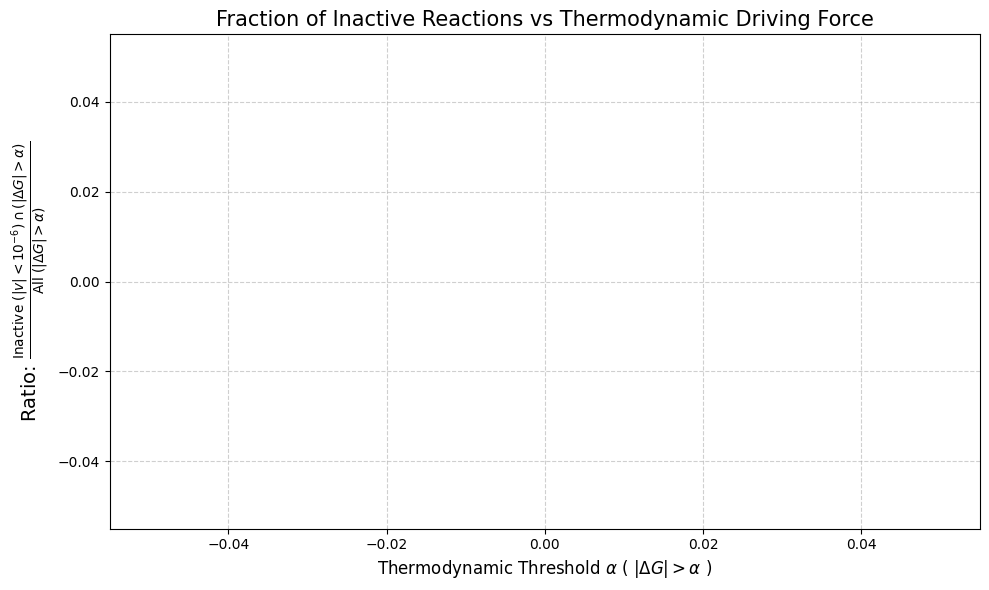

Maximum |dG| found: 10607.9084
Total internal reactions considered: 2253


In [317]:
# C. Calculate Ratios and Plot
# --------------------

if not df.empty:
    # Parameters
    inactivity_threshold = 1e-10
    max_dG = df['abs_dG'].max()
    alpha_values = np.linspace(0, max_dG, 300)
    
    ratios= []
    
    for alpha in alpha_values:
        # Denominator: All reactions with |dG| > alpha
        # Note: We use >= to include the boundary, but > is specified
        subset_thermo = df[(df['abs_dG'] >= alpha) & (df['flux_mag']>1e-9)]
        denom = len(subset_thermo)
        
        if denom == 0:
            ratios.append(np.nan) # Avoid division by zero
            denoms.append(np.nan)
        else:
            # Numerator: Subset that is ALSO inactive (|v| < 1e-6)
            numerator = len(subset_thermo[subset_thermo['flux_mag'] < inactivity_threshold])
            ratios.append(numerator / denom)
            #ratios.append(subset_thermo['flux'][subset_thermo['flux'] >= inactivity_threshold].mean())
            
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values, ratios, color='#d62728', linewidth=2.5) # Red color
    
    plt.title('Fraction of Inactive Reactions vs Thermodynamic Driving Force', fontsize=15)
    plt.xlabel(r'Thermodynamic Threshold $\alpha$ ( $|\Delta G| > \alpha$ )', fontsize=12)
    plt.ylabel(r'Ratio: $\frac{\text{Inactive } (|v| < 10^{-6}) \cap (|\Delta G| > \alpha)}{\text{All } (|\Delta G| > \alpha)}$', fontsize=14)
    
    plt.grid(True, linestyle='--', alpha=0.6)
    #plt.ylim(-0.0001, .003)
    plt.tight_layout()
    plt.show()

    # Optional: Print statistics
    print(f"Maximum |dG| found: {max_dG:.4f}")
    print(f"Total internal reactions considered: {len(df)}")
else:
    print("No internal reactions with valid potentials found.")

In [318]:
df

,id,dG,abs_dG,flux,fwd,rev,flux_mag,log_flux_ratio
0,BIOMASS_Ec_iJO1366_WT_53p95M,1.076582,1.076582,6.500000e-01,1381.634718,1380.984718,6.500000e-01,-4.705679e-04
1,BIOMASS_Ec_iJO1366_core_53p95M,1.084086,1.084086,-9.140422e-11,1381.309680,1381.309680,9.140422e-11,6.616929e-14
2,12DGR120tipp,0.006218,0.006218,1.371291e-09,1381.309680,1381.309680,1.371291e-09,-9.927614e-13
3,12DGR140tipp,0.006219,0.006219,1.371063e-09,1381.309680,1381.309680,1.371063e-09,-9.925394e-13
4,12DGR141tipp,0.006397,0.006397,1.328772e-09,1381.309680,1381.309680,1.328772e-09,-9.620083e-13
...,...,...,...,...,...,...,...,...
2248,RNDR4,0.001215,0.001215,7.385324e-09,1381.309680,1381.309680,7.385324e-09,-5.346612e-12
2249,RNDR4b,0.001212,0.001212,7.401013e-09,1381.309680,1381.309680,7.401013e-09,-5.357936e-12
2250,RNTR1c2,-0.000006,0.000006,1.612324e-02,1381.317741,1381.301618,1.612324e-02,-1.167243e-05
2251,RNTR2c2,-0.000006,0.000006,1.664779e-02,1381.318004,1381.301356,1.664779e-02,-1.205218e-05


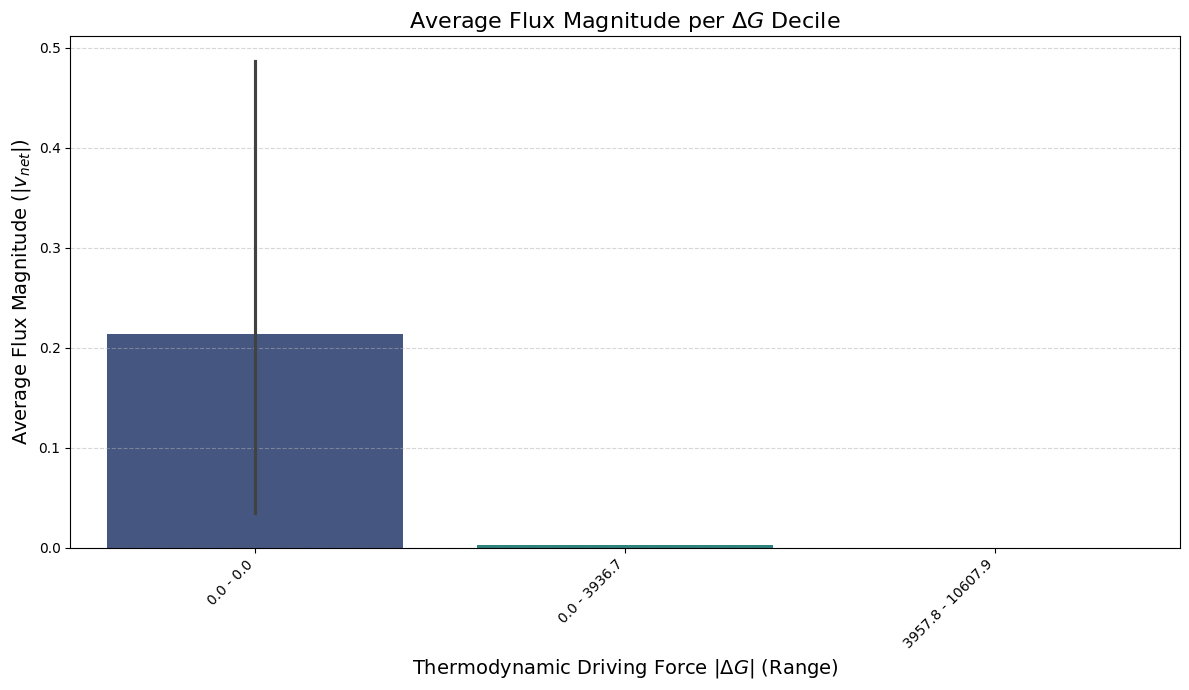


Decile Statistics:
              Label     Mean_Flux  Count
0         0.0 - 0.0  1.354317e-10    226
1         0.0 - 0.0  4.392520e-05    225
2         0.0 - 0.0  5.121317e-03    225
3         0.0 - 0.0  1.777223e-01    225
4         0.0 - 0.0  1.093314e+00    226
5         0.0 - 0.0  3.389471e-01    225
6         0.0 - 0.0  9.612527e-02    225
7         0.0 - 0.0  6.431072e-10    225
8      0.0 - 3936.7  2.888889e-03    225
9  3957.8 - 10607.9  4.355188e-11    226


In [164]:
# C. Decile Analysis and Plotting
if not df.empty:
    # 1. Create Deciles
    # 'qcut' divides into equal-sized buckets. 
    # duplicates='drop' handles cases where many reactions have identical dG (e.g. 0)
    try:
        df['Decile_Rank'] = pd.qcut(df['abs_dG'], 10, labels=False, duplicates='drop')
        
        # Calculate stats per decile
        decile_stats = df.groupby('Decile_Rank').agg({
            'flux': 'mean',
            'abs_dG': ['min', 'max', 'count']
        })
        
        # Flatten columns for easier access
        decile_stats.columns = ['Mean_Flux', 'Min_dG', 'Max_dG', 'Count']
        decile_stats = decile_stats.reset_index()
        
        # Create labels for the x-axis (e.g., "0-2.5", "2.5-5.0")
        decile_stats['Label'] = decile_stats.apply(
            lambda x: f"{x['Min_dG']:.1f} - {x['Max_dG']:.1f}", axis=1
        )
        
        # 2. Plot
        plt.figure(figsize=(12, 7))
        
        # Bar plot
        sns.barplot(
            data=decile_stats,
            x='Label',
            y='Mean_Flux',
            palette='viridis',
            hue='Label',
            legend=False
        )
        
        plt.title('Average Flux Magnitude per $\Delta G$ Decile', fontsize=16)
        plt.xlabel('Thermodynamic Driving Force $|\Delta G|$ (Range)', fontsize=14)
        plt.ylabel('Average Flux Magnitude ($|v_{net}|$)', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
        # Print table for verification
        print("\nDecile Statistics:")
        print(decile_stats[['Label', 'Mean_Flux', 'Count']])
        
    except ValueError as e:
        print(f"Could not compute deciles (likely too many identical dG values): {e}")
else:
    print("No data available to plot.")

<Axes: >

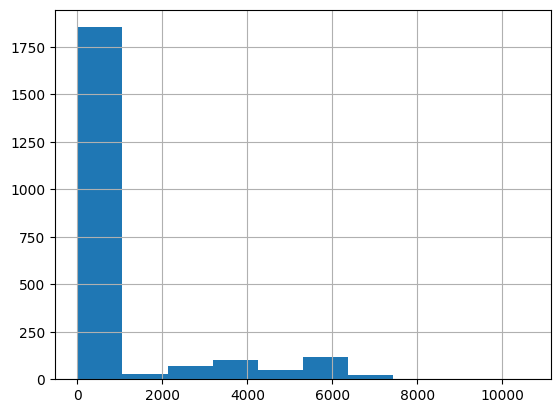

In [165]:
df.abs_dG.hist()

<Axes: >

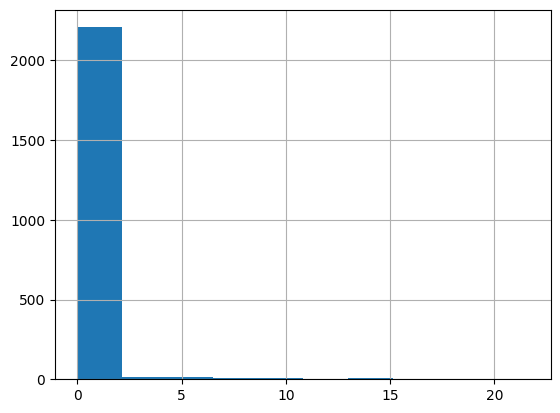

In [166]:
df.flux.hist()

(-25.0, 20.0)

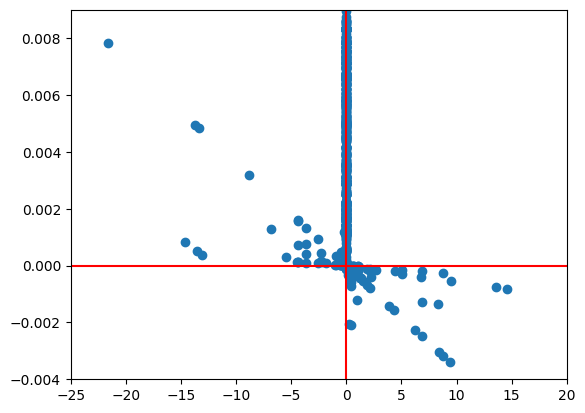

In [299]:
ss=df[(df['flux_mag'] > 0.01) & (df.dG<.8)]
plt.scatter(df.flux,df.dG)
plt.axvline(0,color='red')
plt.axhline(0,color='red')
plt.ylim([-0.004,0.009])
plt.xlim([-25,20])

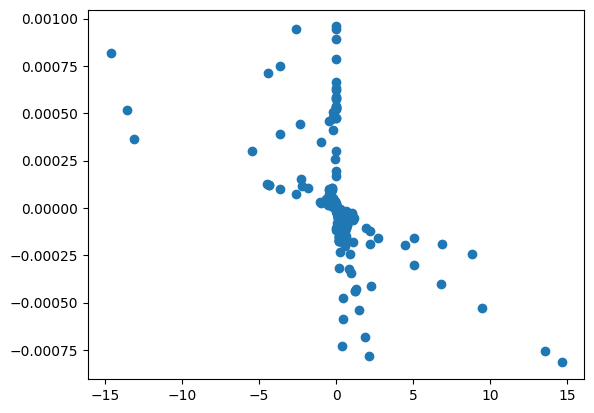

In [296]:
ss=df[(df['abs_dG'] <.001)]
plt.scatter(ss.flux,ss.dG)

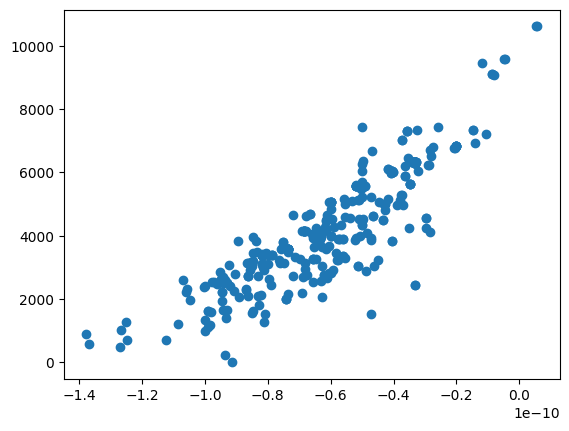

In [284]:
ss=df[(df['abs_dG'] >= 1.077) ]
plt.scatter(ss.flux,ss.dG)

(-1.4e-10, 0.0)

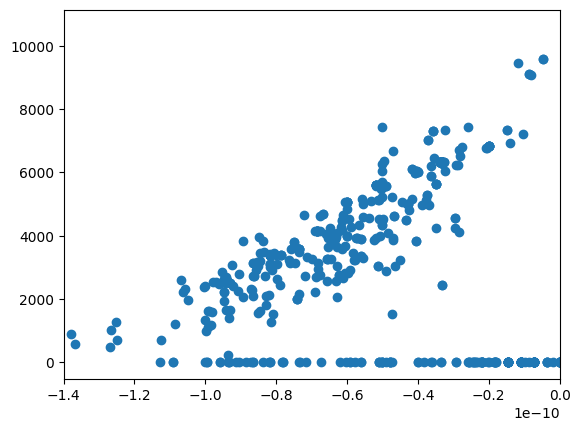

In [287]:
plt.scatter(df.flux,df.dG)
plt.xlim([-1.4e-10,0])

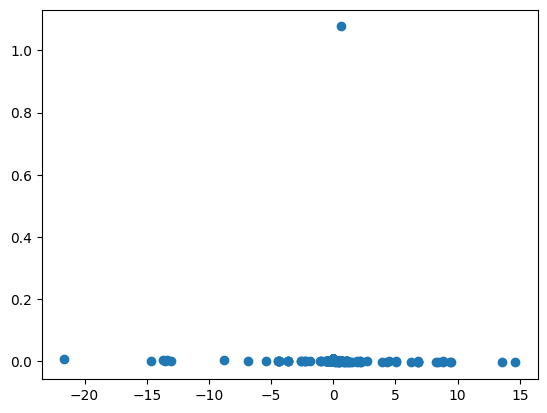

In [307]:
ss=df[(df['flux_mag'] >1e-9)]
plt.scatter(ss.flux,ss.dG)

In [283]:
df.dG.max()

np.float64(10607.90835029849)

In [319]:
df

,id,dG,abs_dG,flux,fwd,rev,flux_mag,log_flux_ratio
0,BIOMASS_Ec_iJO1366_WT_53p95M,1.076582,1.076582,6.500000e-01,1381.634718,1380.984718,6.500000e-01,-4.705679e-04
1,BIOMASS_Ec_iJO1366_core_53p95M,1.084086,1.084086,-9.140422e-11,1381.309680,1381.309680,9.140422e-11,6.616929e-14
2,12DGR120tipp,0.006218,0.006218,1.371291e-09,1381.309680,1381.309680,1.371291e-09,-9.927614e-13
3,12DGR140tipp,0.006219,0.006219,1.371063e-09,1381.309680,1381.309680,1.371063e-09,-9.925394e-13
4,12DGR141tipp,0.006397,0.006397,1.328772e-09,1381.309680,1381.309680,1.328772e-09,-9.620083e-13
...,...,...,...,...,...,...,...,...
2248,RNDR4,0.001215,0.001215,7.385324e-09,1381.309680,1381.309680,7.385324e-09,-5.346612e-12
2249,RNDR4b,0.001212,0.001212,7.401013e-09,1381.309680,1381.309680,7.401013e-09,-5.357936e-12
2250,RNTR1c2,-0.000006,0.000006,1.612324e-02,1381.317741,1381.301618,1.612324e-02,-1.167243e-05
2251,RNTR2c2,-0.000006,0.000006,1.664779e-02,1381.318004,1381.301356,1.664779e-02,-1.205218e-05


(-0.01, 0.01)

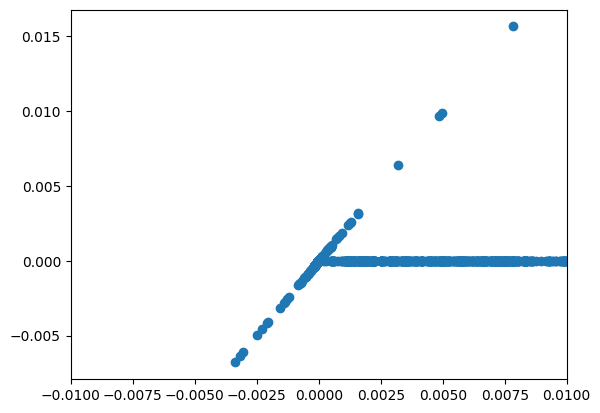

In [328]:
ss=df
plt.scatter(ss.dG,ss.log_flux_ratio)
plt.xlim([-0.01,0.01])

In [388]:
count=0
total=0
zero_count=0
for r in model.reactions:
    if r in model.exchanges: continue
    total += 1
    lb,ub = r.bounds
    if (lb==0 and ub>0) or (lb<0 and ub==0):
        count += 1
        if "R_"+r.id in df_flux.index:
            row=df_flux.loc["R_"+r.id]
            flux_mag=abs(row.forward-row.reverse)
            if flux_mag < 1e-10: 
                zero_count+=1
print(total,count,count/total*100,zero_count,zero_count/count*100)

2259 1637 72.46569278441788 427 26.084300549786192


In [371]:
"BIOMASS_Ec_iJO1366_WT_53p95M" in df["id"]

False

In [369]:
df

,id,dG,abs_dG,flux,fwd,rev,flux_mag,log_flux_ratio
0,BIOMASS_Ec_iJO1366_WT_53p95M,1.076582,1.076582,6.500000e-01,1381.634718,1380.984718,6.500000e-01,-4.705679e-04
1,BIOMASS_Ec_iJO1366_core_53p95M,1.084086,1.084086,-9.140422e-11,1381.309680,1381.309680,9.140422e-11,6.616929e-14
2,12DGR120tipp,0.006218,0.006218,1.371291e-09,1381.309680,1381.309680,1.371291e-09,-9.927614e-13
3,12DGR140tipp,0.006219,0.006219,1.371063e-09,1381.309680,1381.309680,1.371063e-09,-9.925394e-13
4,12DGR141tipp,0.006397,0.006397,1.328772e-09,1381.309680,1381.309680,1.328772e-09,-9.620083e-13
...,...,...,...,...,...,...,...,...
2248,RNDR4,0.001215,0.001215,7.385324e-09,1381.309680,1381.309680,7.385324e-09,-5.346612e-12
2249,RNDR4b,0.001212,0.001212,7.401013e-09,1381.309680,1381.309680,7.401013e-09,-5.357936e-12
2250,RNTR1c2,-0.000006,0.000006,1.612324e-02,1381.317741,1381.301618,1.612324e-02,-1.167243e-05
2251,RNTR2c2,-0.000006,0.000006,1.664779e-02,1381.318004,1381.301356,1.664779e-02,-1.205218e-05


In [375]:
df_flux

,Unnamed: 0,forward,reverse
Reaction_ID,,,
R_EX_cm_e,R_EX_cm_e,1381.309680,1381.309680
R_EX_cmp_e,R_EX_cmp_e,1381.309680,1381.309680
R_EX_co2_e,R_EX_co2_e,1383.500749,1379.122080
R_EX_cobalt2_e,R_EX_cobalt2_e,1381.309672,1381.309687
R_DM_4crsol_c,R_DM_4crsol_c,1381.309752,1381.309607
...,...,...,...
R_RNDR4,R_RNDR4,1381.309680,1381.309680
R_RNDR4b,R_RNDR4b,1381.309680,1381.309680
R_RNTR1c2,R_RNTR1c2,1381.317741,1381.301618


In [380]:
"R_"+r.id in df_flux.index

True

In [383]:
row=df_flux.loc["R_"+r.id]
v=abs(row.forward-row.reverse)

In [384]:
v

np.float64(0.016647786979774537)